## Import Libraries

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import *
from tensorflow.keras.preprocessing.text import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import *
tf.keras.callbacks.History()

## Load Data

In [3]:
# Data Loading
"""
Here in this notebook and model, the data is loaded directly into the notebook instance directly.
Loading data from the drive to notebook instance makes training slower, because of batch loading.
"""
!pip install datasets
from datasets import load_dataset

     |████████████████████████████████| 306 kB 12.8 MB/s 
     |████████████████████████████████| 243 kB 50.0 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 61 kB 454 kB/s 
     |████████████████████████████████| 132 kB 52.1 MB/s 
     |████████████████████████████████| 192 kB 38.9 MB/s 
     |████████████████████████████████| 160 kB 36.8 MB/s 
     |████████████████████████████████| 271 kB 50.9 MB/s 


In [4]:
# split train and test set
train_dataset = load_dataset('yelp_polarity', split = "train")
test_dataset = load_dataset('yelp_polarity', split = "test")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/166M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset yelp_polarity downloaded and prepared to /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/a770787b2526bdcbfc29ac2d9beb8e820fbc15a03afd3ebc4fb9d8529de57544. Subsequent calls will reuse this data.


Reusing dataset yelp_polarity (/root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/a770787b2526bdcbfc29ac2d9beb8e820fbc15a03afd3ebc4fb9d8529de57544)


In [5]:
# converting to dataframe
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

In [6]:
# labels 0: Negative, 1: Postive 
# train set first 10 rows
train_df.head(5)

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


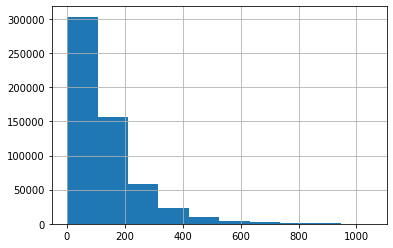

In [7]:
# get length of all the reviews in the train set
seq_len = [len(i.split()) for i in train_df["text"]]

pd.Series(seq_len).hist(bins = 10)

In [8]:
# Get percentile of seq len
s= pd.Series(seq_len)
s.quantile([.50, .60, .70, .75, .80, .85, .90, .95,.98, .99])

0.50     97.0
0.60    121.0
0.70    153.0
0.75    174.0
0.80    199.0
0.85    232.0
0.90    282.0
0.95    372.0
0.98    501.0
0.99    608.0
dtype: float64

## Data Preprocessing

In [9]:
# Data preprocessing, clean the text
def text_prep(text):
  text = text.lower()
  text = text.encode('ascii', 'ignore').decode()
  text = re.sub(r'https*\S+', ' ', text)
  text = re.sub(r'@\S+', ' ', text)
  text = re.sub(r'#\S+', ' ', text)
  text = re.sub(r'\'\w+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub(r'\w*\d+\w*', '', text)
  text = re.sub(r'\s{2,}', ' ', text)
  return text

In [10]:
# apply the text prep mthod for cleaning data
train_df['text'] = train_df.text.apply(text_prep)
test_df['text'] = test_df.text.apply(text_prep)

In [11]:
#train_test split
X_train, y_train = train_df['text'].values, train_df['label'].values
X_test, y_test = test_df['text'].values, test_df['label'].values

In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train[:2])
print(y_train[:2])
print(X_test[:2])
print(y_test[:2])

(560000,) (560000,)
(38000,) (38000,)
['unfortunately the frustration of being dr goldberg patient is a repeat of the experience i had with so many other doctors in nyc good doctor terrible staff it seems that his staff simply never answers the phone it usually takes hours of repeated calling to get an answer who has time for that or wants to deal with it i have run into this problem with many other doctors and i just don get it you have office workers you have patients with medical needs why isn anyone answering the phone it incomprehensible and not work the aggravation it with regret that i feel that i have to give dr goldberg stars '
 'been going to dr goldberg for over years i think i was one of his patients when he started at mhmg he been great over the years and is really all about the big picture it is because of him not my now former gyn dr markoff that i found out i have fibroids he explores all options with you and is very patient and understanding he doesn judge and asks all

In [13]:
#Tokenize the sentences
tokenizer = Tokenizer()

In [14]:
#preparing vocabulary
tokenizer.fit_on_texts(list(X_train))

In [15]:
#converting text into integer sequences
X_train_seq  = tokenizer.texts_to_sequences(X_train) 
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [16]:
print(X_train_seq[:2])
print(X_test_seq[:2])

[[682, 1, 4211, 8, 167, 906, 43242, 1592, 11, 5, 2093, 8, 1, 133, 3, 24, 20, 27, 183, 80, 3011, 10, 2538, 34, 1304, 443, 125, 7, 497, 13, 171, 125, 776, 87, 3704, 1, 430, 7, 374, 812, 347, 8, 4020, 1395, 4, 44, 60, 1229, 112, 93, 46, 9, 13, 49, 1634, 4, 402, 20, 7, 3, 23, 544, 172, 17, 442, 20, 183, 80, 3011, 2, 3, 40, 77, 44, 7, 16, 23, 620, 1303, 16, 23, 3131, 20, 2829, 614, 217, 412, 453, 4182, 1, 430, 7, 24079, 2, 22, 206, 1, 10374, 7, 20, 2199, 13, 3, 238, 13, 3, 23, 4, 158, 906, 43242, 227], [69, 113, 4, 906, 43242, 9, 92, 264, 3, 138, 3, 6, 45, 8, 171, 3131, 48, 62, 405, 25, 108961, 62, 69, 52, 92, 1, 264, 2, 11, 64, 37, 56, 1, 209, 1361, 7, 11, 72, 8, 219, 22, 14, 159, 2996, 16576, 906, 84260, 13, 3, 256, 36, 3, 23, 71641, 62, 50485, 37, 501, 20, 16, 2, 11, 42, 1592, 2, 3025, 62, 379, 2800, 2, 2361, 37, 1, 143, 1016, 42, 3406, 2, 1634, 4, 30, 569, 10, 1, 6838, 21, 187, 3818, 8, 71, 2829, 1604, 2, 71, 603]]
[[7902, 4, 80, 322, 3, 23, 1320, 1502, 56, 1, 53, 49, 1, 245, 3, 23, 69,

In [17]:
"""we give max length as 400 as 95 percent of the data is having 400 length
   The longest length of senetence in data is 1039"""

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1
# Get max training sequence length
max_seq_length = max([len(x) for x in X_train_seq])
max_length= 400

In [18]:
print(f"vocab_size: {vocab_size}")
print(f"max seq length: {max_seq_length}")
print(f"max_length: {max_length}")

vocab_size: 204199
max seq length: 1039
max_length: 400


In [19]:
#padding to prepare sequences of same length
X_train_seq  = sequence.pad_sequences(X_train_seq, maxlen=max_length)
X_test_seq = sequence.pad_sequences(X_test_seq, maxlen=max_length)

In [20]:
# saving tokenizer
with open("tokenizer.pickle", "wb") as lstm_tokenizer:
    pickle.dump(tokenizer, lstm_tokenizer, protocol=pickle.HIGHEST_PROTOCOL)

## Load GloVe

In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-23 18:34:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-23 18:34:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-23 18:34:41--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [22]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()


In [23]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
print("Loaded %s word vectors:" % len(embeddings_index))
print(embedding_matrix.shape)

Loaded 400000 word vectors:
(204199, 300)


## Model LSTM

In [25]:
model=Sequential()

#embedding layer
model.add(Embedding(vocab_size, 300 ,weights=[embedding_matrix], input_length= max_length, trainable=False)) 

#lstm layer
model.add(LSTM(128, return_sequences=True, dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 300)          61259700  
                                                                 
 lstm (LSTM)                 (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61,487,669
Trainable params: 227,969
Non-trainable params: 61,259,700
______________________________________

In [26]:
history = model.fit(np.array(X_train_seq), np.array(y_train), batch_size = 256, epochs=20, validation_split= 0.10, verbose=1, callbacks=[es,mc])

Epoch 1/20
1969/1969 [==============================] - ETA: 0s - loss: 0.2054 - acc: 0.9147
Epoch 00001: val_acc improved from -inf to 0.95561, saving model to best_lstm_model.h5
1969/1969 [==============================] - 330s 165ms/step - loss: 0.2054 - acc: 0.9147 - val_loss: 0.1133 - val_acc: 0.9556
Epoch 2/20
1969/1969 [==============================] - ETA: 0s - loss: 0.1412 - acc: 0.9441
Epoch 00002: val_acc improved from 0.95561 to 0.96170, saving model to best_lstm_model.h5
1969/1969 [==============================] - 324s 165ms/step - loss: 0.1412 - acc: 0.9441 - val_loss: 0.0990 - val_acc: 0.9617
Epoch 3/20
1969/1969 [==============================] - ETA: 0s - loss: 0.1252 - acc: 0.9509
Epoch 00003: val_acc improved from 0.96170 to 0.96200, saving model to best_lstm_model.h5
1969/1969 [==============================] - 324s 164ms/step - loss: 0.1252 - acc: 0.9509 - val_loss: 0.0993 - val_acc: 0.9620
Epoch 4/20
1969/1969 [==============================] - ETA: 0s - loss: 0

## Saving Model weights

In [27]:
#loading best model
from keras.models import load_model
model = load_model('best_lstm_model.h5')

#evaluation 
_, val_acc = model.evaluate(X_test_seq, y_test, batch_size=256)
print(val_acc)

149/149 [==============================] - 8s 53ms/step - loss: 0.1085 - acc: 0.9600
0.9599999785423279


In [28]:
# Plotting train and validation accuracy
import matplotlib.pyplot as plt
def display_plot(history,train,validation):
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.title('Train/Validation accuracy Vs No. of epochs')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

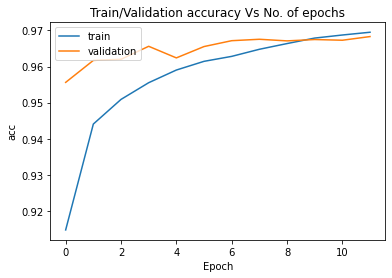

In [29]:
display_plot(history,'acc','val_acc')

## Model Evaluation

In [30]:
# Prediction on test dataset
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")

In [31]:
# Print a classification report
cls_rep= classification_report(y_test, y_pred)
print(cls_rep)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19000
           1       0.96      0.96      0.96     19000

    accuracy                           0.96     38000
   macro avg       0.96      0.96      0.96     38000
weighted avg       0.96      0.96      0.96     38000



In [32]:
# Report the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[18321   679]
 [  841 18159]]


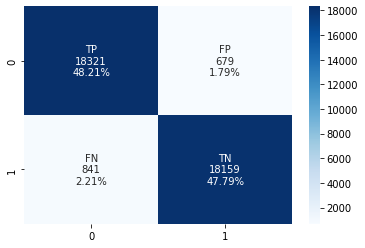

In [33]:
# Plotting confusion matrix
group_names = ["TP","FP","FN","TN"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

In [34]:
print("End of the note book.\nThe next notebook will be sentiment analysis using BERT")

End of the note book.
The next notebook will be sentiment analysis using BERT
